In [4]:
import pandas as pd

answers = pd.read_csv("data/Spring2025_CoT_Answers.csv")
varlist = pd.read_csv("data/variable_list.csv")
#extract the variables
background_vars = varlist["Variable"].dropna().tolist()
background_vars


['Student',
 'Assignment',
 'Class',
 'Activities',
 'CheapFlights.3a_MC',
 'CheapFlights.3b_OE',
 'CheapFlights.4a_MC',
 'CheapFlights.4b_OE',
 'Travel.00a_OE',
 'Travel.00bc_OEOE',
 'Travel.00bc_OEOE follow up',
 'Travel.00a_MC',
 'Travel.00b_MC',
 'Travel.01_NU',
 'Travel.01_NU 1',
 'Travel.02ab_MCNU',
 'Travel.02ab_MCNU follow up',
 'Travel.03_MC',
 'Travel.04ab_MCOE',
 'Travel.04ab_MCOE follow up',
 'Park.01_MC',
 'Park.02_MC',
 'Park.03_NU',
 'Park.03_NU 1',
 'Park.04a_MC',
 'Park.04b_MC',
 'Market.00a_MC',
 'Market.00b_MC',
 'Market.01a_MC',
 'Market.01b_MC',
 'Market.01c_MC',
 'Market.01d_MC',
 'Market.02b_FB',
 'Market.02b_FB 1',
 'Market.02b_FB 2',
 'Market.02b_FB 3',
 'Market.02b_FB 4',
 'Delivery.00a_MC',
 'Delivery.00b_ME',
 'Delivery.00b_ME 1',
 'Delivery.00b_ME 2',
 'Delivery.00b_ME 3',
 'Delivery.00b_ME 4',
 'Delivery.00b_ME 5',
 'Delivery.00b_ME 6',
 'Delivery.00b_ME 7',
 'Delivery.01a_MC',
 'Delivery.01b_MC',
 'Delivery.01c_MC',
 'Delivery.02a_MC',
 'Delivery.02b_NU',

In [5]:
#step1: use the variables in the list to summarize the counts for each answer for each question (for vars that starts with 'D.')
background_vars_ac = [v for v in background_vars if v.startswith("D.")]
summary_overall = {}
for var in background_vars_ac:
    if var in answers.columns:
        summary_overall[var] = (
            answers[var]
            .value_counts(dropna=False)
            .rename_axis("Response")
            .reset_index(name="Count")
        )
summary_overall

{'D.01_Consent':   Response  Count
 0        a    234
 1        -      1,
 'D.02_Class':                                              Response  Count
 0                                                   a    155
 1                                                   b     66
 2                                other:'Mechatronics'      3
 3                                                 NaN      1
 4                                    other:'Robotics'      1
 5   other:'Robotics and Engineering Vocational Class'      1
 6                  other:'Robotics and Engineering 2'      1
 7                                other:'mechatronics'      1
 8                              other:'Robotics Class'      1
 9                              other:'Mechatronics 2'      1
 10                     other:'robotics/ mechatronics'      1
 11                               other:'AP physics 1'      1
 12                                           other:''      1
 13                                         

In [6]:
#build new column in answers to collect their race/ethinicity 
HISP = "D.08_hispanic_YN"
RACE = "D.09_Race_ethnicity"
OUT  = "race.ethn.r"

h = answers[HISP].astype(str).str.strip().str.lower()

# Default: keep original race
answers[OUT] = answers[RACE]

# Override when Hispanic == Yes
answers.loc[h.eq("a"), OUT] = "Hispanic/Latino"

n_hisp = int(answers["race.ethn.r"].astype(str).str.strip().str.lower().eq("hispanic/latino").sum())
print("Hispanic/Latino rows:", n_hisp)


Hispanic/Latino rows: 66


You should consider upgrading via the '/usr/local/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


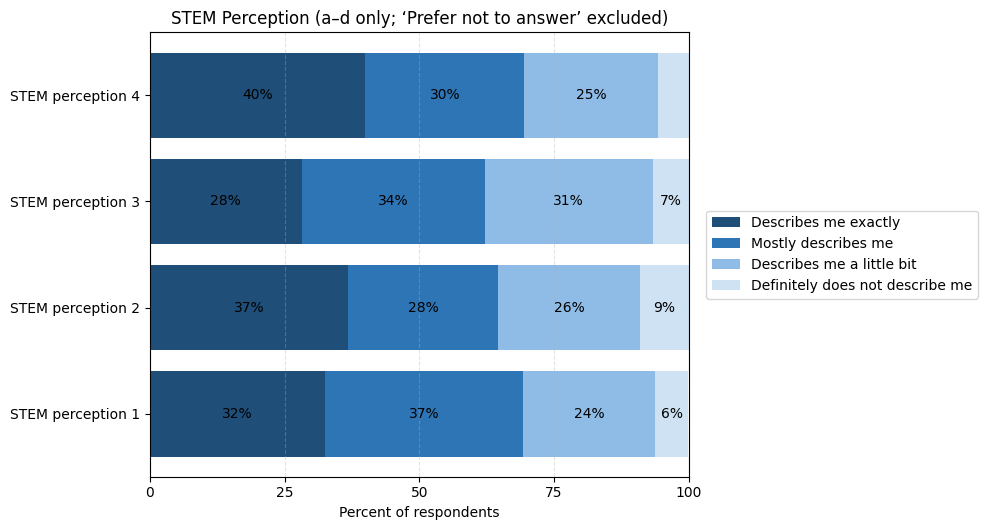

In [7]:
%pip install matplotlib
import matplotlib.pyplot as plt
import numpy as np
# 2) Pick the perception items (your headers look like D.14_STEM_…)
cols = answers.filter(regex=r'^D\.14_STEM_.*\d\s*$').columns.tolist()
if not cols:
    raise ValueError("No columns found starting with 'D.14_STEM_'")

# normalize to single letters a/b/c/d/e
dfL = answers[cols].apply(lambda s: s.astype(str).str.strip().str.lower().str[0])

COLORS = {
    "a": "#1f4e79",  # darkest: Describes me exactly
    "b": "#2e75b6",
    "c": "#8fbce6",
    "d": "#cfe2f3",  # lightest: Definitely does not describe me
}

ORDER  = ["a","b","c","d"]  # keep these four; drop 'e'
LABELS = {
    "a": "Describes me exactly",
    "b": "Mostly describes me",
    "c": "Describes me a little bit",
    "d": "Definitely does not describe me",
}

# 3) Build a % table per item (exclude e/NaN)
rows = []
for c in cols:
    s = dfL[c].where(dfL[c].isin(ORDER))              # a–d; others -> NaN
    denom = int(s.notna().sum())
    pct = (s.value_counts().reindex(ORDER, fill_value=0) / (denom or 1) * 100).round(1)
    pct.name = c
    rows.append(pct)

wide = pd.DataFrame(rows)           # shape: n_items × 4
wide.index.name = "Question"

# tidy y-axis labels
pretty_names = [c.replace("D.14_", "").replace("_", " ").strip() for c in wide.index]
wide.index = pretty_names

# 4) Plot – 100% stacked bars (a–d)
fig, ax = plt.subplots(figsize=(10, 4 + 0.35*len(wide)))

left = np.zeros(len(wide))
ypos = np.arange(len(wide))

for k in ORDER:
    vals = wide[k].to_numpy()
    bars = ax.barh(ypos, vals, left=left,
               color=COLORS[k], edgecolor="none",  # CHANGED
               label=LABELS[k])
    # add % labels inside segments if wide enough
    for rect, v in zip(bars, vals):
        if v >= 6:  # avoid clutter on tiny segments
            ax.text(rect.get_x() + rect.get_width()/2,
                    rect.get_y() + rect.get_height()/2,
                    f"{v:.0f}%",
                    ha="center", va="center", fontsize=10)
    left += vals

ax.set_yticks(ypos, wide.index)
ax.set_xlim(0, 100)
ax.set_xticks([0, 25, 50, 75, 100])
ax.set_xlabel("Percent of respondents")
ax.set_title("STEM Perception (a–d only; ‘Prefer not to answer’ excluded)")
plt.subplots_adjust(right=0.78)                         # ADDED
ax.legend(loc="center left", bbox_to_anchor=(1.02, 0.5), ncols=1, frameon=True)  # CHANGED
ax.grid(axis="x", linestyle="--", alpha=0.35)

plt.tight_layout()
plt.show()
